<a href="https://colab.research.google.com/github/janehung04/w266-final/blob/dev/src/run-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explore Data
**Author:** Jane Hung  
**Date:** 1 Mar 2020  
**Citations:**  
@inproceedings{xu_bert2019,
    title = "BERT Post-Training for Review Reading Comprehension and Aspect-based Sentiment Analysis",
    author = "Xu, Hu and Liu, Bing and Shu, Lei and Yu, Philip S.",
    booktitle = "Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics",
    year = "2019",
}  
https://drive.google.com/file/d/1NGH5bqzEx6aDlYJ7O3hepZF4i_p4iMR8/view

## Initialize environment

In [7]:
!pip install transformers
!pip install vaderSentiment

In [8]:
import pandas as pd
import numpy as np
import os
import sys
import json
import pprint
import tensorflow as tf
from time import time
import io
import re

import nltk

import pickle
from csv import reader


import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy, int_shape
from tensorflow.keras.layers import Dense, Flatten
import tensorflow.keras as keras

from datetime import datetime

from transformers import BertTokenizer, TFBertModel,TFBertForSequenceClassification

from collections import Counter
import random

from sklearn.metrics import log_loss, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [9]:
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

## Helper functions

In [10]:
def read_json(filename):
    f = open(filename,'r')
    data = json.loads(f.read())
    print('\n',filename)
    pprint.pprint(dict(list(data.items())[:1]))
    return(data)

## Import data

### Training data

In [11]:

!pwd

/content


In [12]:
ae_laptop_train = read_json('../data/hu-data/ae/laptop/train.json')


asc_laptop_train = read_json('../data/hu-data/asc/laptop/train.json')


 ../data/hu-data/ae/laptop/train.json
{'0': {'label': ['B',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'B',
                 'I',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['Keyboard',
                    'is',
                    'great',
                    'but',
                    'primary',
                    'and',
                    'secondary',
                    'control',
                    'buttons',
                    'could',
                    'be',
                    'more',
                    'durable',
                    '.']}}

 ../data/hu-data/asc/laptop/train.json
{'327_0': {'id': '327_0',
           'polarity': 'positive',
           'sentence': 'Also it is very good for college students who just '
                       'need a reliable, easy to use computer.',
 

### Dev data

In [13]:
ae_laptop_dev  = read_json('../data/hu-data/ae/laptop/dev.json')


asc_laptop_dev = read_json('../data/hu-data/asc/laptop/dev.json')


 ../data/hu-data/ae/laptop/dev.json
{'0': {'label': ['O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['I',
                    'have',
                    'had',
                    'this',
                    'laptop',
                    'for',
                    'a',
                    'few',
                    'months',
                    'now',
                    'and',
                    'i',
                    'would',
                    'say',
                    'im',
                    'pretty',
                    'satisfied',
                    '.']}}

 ../data/hu-data/asc/laptop/dev.json
{'1113_0': {'id': '1113_0',
  

### Test data

In [14]:
ae_laptop_test  = read_json('../data/hu-data/ae/laptop/test.json')


asc_laptop_test = read_json('../data/hu-data/asc/laptop/test.json')


 ../data/hu-data/ae/laptop/test.json
{'0': {'label': ['B',
                 'I',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O',
                 'O'],
       'sentence': ['Boot',
                    'time',
                    'is',
                    'super',
                    'fast',
                    ',',
                    'around',
                    'anywhere',
                    'from',
                    '35',
                    'seconds',
                    'to',
                    '1',
                    'minute',
                    '.']}}

 ../data/hu-data/asc/laptop/test.json
{'718:1_0': {'id': '718:1_0',
             'polarity': 'positive',
             'sentence': 'the retina display display make pictures i took '
                         'year

### Convert to df

In [15]:
ae_laptop_train_df = pd.DataFrame.from_dict(ae_laptop_train,orient='index')
ae_laptop_train_df.head()

ae_laptop_dev_df = pd.DataFrame.from_dict(ae_laptop_dev,orient='index')
ae_laptop_dev_df.head()

ae_laptop_test_df = pd.DataFrame.from_dict(ae_laptop_test,orient='index')
ae_laptop_test_df

,label,sentence
0,"[B, O, O, O, O, O, O, B, I, O, O, O, O, O]","[Keyboard, is, great, but, primary, and, secon..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[I, bought, this, laptop, about, a, month, ago..."
2,"[O, O, O, O, O, O, O, O, O, O, O, O]","[I, am, however, pleased, that, it, is, still,..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[I, went, to, my, local, Best, Buy, looking, f..."
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[The, Apple, MC371LL/, A, 2.4Ghz, 15.4-, inch,..."


,label,sentence
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[I, have, had, this, laptop, for, a, few, mont..."
1,"[O, O, O, O, B, I, O, O, O, O, O, O, B, O, O, ...","[Additional, caveat, :, the, base, installatio..."
2,"[O, O, O, O, B, O, O, O, O, B, O, O, O, O, O, ...","[it, is, of, high, quality, ,, has, a, killer,..."
3,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O]","[The, screen, gets, smeary, and, dusty, very, ..."
4,"[O, O, O, O, O, O, O, O, O, O, O]","[I, previously, owned, an, HP, desktop, and, a..."


,label,sentence
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh..."
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,..."
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]"
3,"[B, I, O, O, O]","[Set, up, was, easy, .]"
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t..."
...,...,...
795,"[O, B, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[This, hardware, seems, to, be, better, than, ..."
796,"[O, O, O, O, O, O, O]","[I, 'm, done, with, WinDoze, computers, .]"
797,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, ...","[I, 've, had, it, for, about, 2, months, now, ..."
798,"[O, O, O, O, O, O, O, B, I, O]","[the, latest, version, does, not, have, a, dis..."


In [16]:
asc_laptop_train_df = pd.DataFrame.from_dict(asc_laptop_train,orient='index')
asc_laptop_train_df.head()
asc_laptop_dev_df = pd.DataFrame.from_dict(asc_laptop_dev,orient='index')
asc_laptop_dev_df.head()
asc_laptop_test_df = pd.DataFrame.from_dict(asc_laptop_test,orient='index')
asc_laptop_test_df.head()

,polarity,term,id,sentence
327_0,positive,use,327_0,Also it is very good for college students who ...
3077_0,positive,noise,3077_0,For those that care about noise this thing doe...
1592_1,positive,force,1592_1,Enjoy that Toshib force and durability unparal...
329_0,negative,expense,329_0,I know that everyone thinks Macs are overprice...
1184_0,negative,word processor,1184_0,) And printing from either word processor is a...


,polarity,term,id,sentence
1113_0,negative,safe mode,1113_0,Not even safe mode boots.
2595_0,positive,Keyboard,2595_0,Keyboard was also very nice and had a solid feel.
1039_0,negative,Keyboard,1039_0,Keyboard is plastic and spongey feeling.
315_0,positive,quality,315_0,I would recommend this laptop to anyone lookin...
1284_0,negative,screen,1284_0,"Thus, when you carry it at a slanted angle, th..."


,polarity,term,id,sentence
718:1_0,positive,retina display display,718:1_0,the retina display display make pictures i too...
217:1_1,neutral,CD/DVD drive,217:1_1,Needs a CD/DVD drive and a bigger power switch.
217:1_0,negative,power switch,217:1_0,Needs a CD/DVD drive and a bigger power switch.
1044:1_0,negative,battery,1044:1_0,The battery is not as shown in the product pho...
1040:1_0,negative,keyboard,1040:1_0,"It feels cheap, the keyboard is not very sensi..."


# AE

## AE baseline - NN+

In [17]:
def pos_ae(tokenized_sentence):
    """
    Tag sentences using POS tagger and identify consecutive nouns as entities
    """
    pos_sent = tokenized_sentence.apply(lambda sent:nltk.pos_tag(sent,tagset='universal'))
    
    
    # tag with IOB terminology
    ae_tag = lambda sent:['O' if token[1] != 'NOUN' 
                          else 'B' if ((token[1]=='NOUN') & ((sent[ind-1][1]!='NOUN') | (ind==0))) 
                          else 'I' for ind,token in enumerate(sent)]

    return(pos_sent.apply(ae_tag))

# since the POS tagger is based on the words themselves and not context.
ae_laptop_test_df['predictions'] = pos_ae(ae_laptop_test_df['sentence'])
ae_laptop_test_df.head()

def convert_int(tagged_tokens):
    """
    Convert B,I,O tags to integers
    """
    return(tagged_tokens.apply(lambda sent: [0 if token=='O' else 1 if token=='B' else 2 for token in sent]))

convert_int(ae_laptop_test_df['predictions'])


,label,sentence,predictions
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh...","[B, I, O, O, O, O, O, O, O, O, B, O, O, B, O]"
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ..."
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]","[O, O, B, O, B, O, O]"
3,"[B, I, O, O, O]","[Set, up, was, easy, .]","[B, O, O, O, O]"
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t...","[B, O, O, O, O, B, O, O, O, B, O]"


0          [1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]
1      [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...
2                                  [0, 0, 1, 0, 1, 0, 0]
3                                        [1, 0, 0, 0, 0]
4                      [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
                             ...                        
795    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
796                                [0, 0, 0, 0, 1, 2, 0]
797    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...
798                       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
799     [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Name: predictions, Length: 800, dtype: object

## AE Regex Parser - business rules

In [18]:
# try a more sophisticated method for chunking
def regex_parser(tokenized_sentence,verbose=False):
    """
    Use a Regex Parser to provide some context around noun phrases
    """
    pos_sent = nltk.pos_tag(tokenized_sentence)
#     print(pos_sent)
#     grammar = r"""
#       NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
#           {<NNP>+}                # chunk sequences of proper nouns
#     """
    
    # Update Grammar Regex to include prepositional phrases ala Semeval annotation guidelines
    grammar = r"""
    NP: {<NN><IN><DT><NN|NNP>+}
        {<NNP><NN>}
        {<NNP>+}
        {<NN>+}
        
    """
    
    cp = nltk.RegexpParser(grammar)

    tree = cp.parse(pos_sent)
    
    if verbose: print(tree)
    
    iob = [el[2][0] for el in nltk.chunk.util.tree2conlltags(tree)]
    return(iob)

# since the POS tagger is based on the words themselves and not context.
ae_laptop_test_df['predictions_1'] = ae_laptop_test_df['sentence'].apply(lambda x: regex_parser(x))
ae_laptop_test_df.head()


,label,sentence,predictions,predictions_1
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh...","[B, I, O, O, O, O, O, O, O, O, B, O, O, B, O]","[B, I, O, O, O, O, O, O, O, O, O, O, O, B, O]"
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ..."
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]","[O, O, B, O, B, O, O]","[O, O, B, O, B, O, O]"
3,"[B, I, O, O, O]","[Set, up, was, easy, .]","[B, O, O, O, O]","[B, O, O, O, O]"
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t...","[B, O, O, O, O, B, O, O, O, B, O]","[B, O, O, O, O, B, O, O, O, O, O]"


## AE BERT

### Format BERT inputs

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
batch_sentences = [val['sentence'] for key, val in ae_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_test.items()])
train_size = len(ae_laptop_train)*5
dev_size = len(ae_laptop_dev)
test_size = len(ae_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
assert len(batch_sentences) == train_size+dev_size+test_size

14475
150
800


In [21]:
batch_label = [val['label'] for key, val in ae_laptop_train.items()]*5
batch_label.extend([val['label'] for key, val in ae_laptop_dev.items()])
batch_label.extend([val['label'] for key, val in ae_laptop_test.items()])

len(batch_label)

15425

In [22]:
def addWord(word, ner):
    """
    Convert a word into a word token and add supplied NER labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

In [23]:
max_length = 50

In [24]:
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
nerTokens = ['[nerCLS]']

for sentence,label in zip(batch_sentences,batch_label):
    for ind,token in enumerate(sentence):
        word, ner = token,label[ind]

        # if new sentence starts
        if (ind == 0):            

            sentenceLength = min(max_length -1, len(sentenceTokens))
            sentLengthList.append(sentenceLength)

            # Create space for at least a final '[SEP]' token
            if sentenceLength >= max_length - 1: 
                sentenceTokens = sentenceTokens[:max_length - 2]
                nerTokens = nerTokens[:max_length - 2]

            # add a ['SEP'] token and padding

            sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
            nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

            sentenceList.append(sentence)

            sentenceTokenList.append(sentenceTokens)

            bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
            bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
            bertSequenceIDs.append([0] * (max_length))

            nerTokenList.append(nerTokens)

            sentence = ''
            sentenceTokens = ['[CLS]']
            nerTokens = ['[nerCLS]']

            sentence += ' ' + word

        addDict = addWord(word, ner)

        sentenceTokens += addDict['wordToken']
        nerTokens += addDict['nerToken']

In [25]:
print(sentenceTokenList[1])

['[CLS]', 'keyboard', 'is', 'great', 'but', 'primary', 'and', 'secondary', 'control', 'buttons', 'could', 'be', 'more', 'durable', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [26]:
print(nerTokenList[1])

['[nerCLS]', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [27]:
print(bertMasks[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [28]:
print(bertSequenceIDs[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(array([  1.,   0.,  10., 187., 240., 358., 543., 500., 685., 686., 618.,
        721., 743., 825., 761., 728., 714., 556., 565., 533., 462., 521.,
        372., 387., 372., 433., 294., 295., 212., 179., 202., 165., 151.,
        145., 140., 109., 105.,  77.,  73.,  87.,  68.,  64.,  60.,  55.,
         36.,  50.,  41., 296.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <a list of 48 Patch objects>)

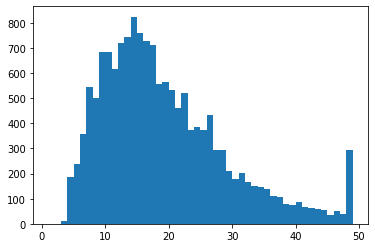

In [29]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [30]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1)

In [31]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [32]:
bert_inputs.shape

(3, 15425, 50)

In [33]:
trainSentence_ids = bert_inputs[0][:train_size]
trainMasks = bert_inputs[1][:train_size]
trainSequence_ids = bert_inputs[2][:train_size]

devSentence_ids = bert_inputs[0][train_size:train_size+dev_size]
devMasks = bert_inputs[1][train_size:train_size+dev_size]
devSequence_ids = bert_inputs[2][train_size:train_size+dev_size]

testSentence_ids = bert_inputs[0][train_size+dev_size:]
testMasks = bert_inputs[1][train_size+dev_size:]
testSequence_ids = bert_inputs[2][train_size+dev_size:]

nerLabels_train = nerLabels[:train_size]
nerLabels_dev = nerLabels[train_size:train_size+dev_size]
nerLabels_test = nerLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_dev = np.array(nerLabels_dev)
nerLabels_test = np.array(nerLabels_test)

In [34]:
trainSentence_ids.shape
devSentence_ids.shape
testSentence_ids.shape

(14475, 50)

(150, 50)

(800, 50)

In [35]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_dev_k = nerLabels_dev[k_start:k_end_dev]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [36]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [37]:
numNerClasses = 7

### Construct BERT model

In [38]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label==y_label) #(y_label < 3)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, numNerClasses])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))

In [39]:
def custom_acc_orig_tokens(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    
    y_label = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    mask = (y_label==y_label) #(y_label < 3)
    y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.keras.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numNerClasses]), axis=1)
    
    y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted_masked,y_label_masked) , dtype=tf.float64))

In [40]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0000005) #, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False

In [41]:
def ner_model(max_input_length, train_layers, optimizer):
    """
    Implementation of NER model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[0]
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.1), name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(numNerClasses, activation='softmax', name='ner')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {
        "ner": custom_loss,
        }
    lossWeights = {"ner": 1.0
                  }
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=losses, optimizer=optimizer, metrics=[custom_acc_orig_tokens])
    
    
    model.summary()
    
    return model

In [42]:
print(bert_inputs_train_k[0][1])
print(labels_train_k[1])

[  101  9019  2003  2307  2021  3078  1998  3905  2491 11287  2071  2022
  2062 25634  1012   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[3 0 2 2 2 2 2 2 0 1 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [43]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
model = ner_model(max_length + 1, train_layers=-1, optimizer = adam_customized)

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_dev_k, {"ner": labels_dev_k }),
    epochs=10,
    batch_size=8
    #shuffle = True #since we have 5 duplicates of each
)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 50, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 50, 7), dtype=tf.float32, name=None), name='ner/truediv:0', description="created by layer 'ner'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
___________________________________________________________________________

### Predict on test

In [44]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]
result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [45]:
print(np.argmax(result, axis=2)[8])

[3 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [46]:
print(nerLabels_test[8])

[3 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


### Format BERT results

In [47]:
# build a dataframe that we can index
nerClassDict = nerClasses[['tag','cat']].drop_duplicates().sort_values('cat')
nerClassDict = list(nerClassDict.tag.values.tolist())
nerClassDict

['B', 'I', 'O', '[nerCLS]', '[nerPAD]', '[nerSEP]', 'nerX']

In [48]:
# index categorical label dataframe for the predicted tag
format_result = []
for sample in np.argmax(result, axis=2):
    format_result.append([nerClassDict[label] for label in sample])
    
len(format_result)

800

In [49]:
# index categorical label dataframe for the true tag
format_label = []
for sample in nerLabels_test:
    format_label.append([nerClassDict[label] for label in sample])
    
len(format_label)

800

In [50]:
# get real tokens back
format_sent = [tokenizer.convert_ids_to_tokens(sample) for sample in X_test[0]]

In [51]:
predictions_flat = [pred for preds in format_result for pred in preds]
labels_flat = [label for labels in format_label for label in labels]
sentence_flat = [token for sample in X_test[0] for token in tokenizer.convert_ids_to_tokens(sample)]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label in ['O','B','I','nerX']:
        clean_preds.append(pred)
        clean_labels.append(label)
print(Counter(clean_preds))
print(confusion_matrix(clean_labels,clean_preds))

Counter({'O': 10817, 'nerX': 868, 'B': 667, 'I': 343})
[[  554    10    84     0]
 [   51   315    81     0]
 [   62    18 10625    17]
 [    0     0    27   851]]


In [52]:
def bert_entities(sentence_list,label_list):
  # may not need this after all
  all_entities = []
  for full_sentence, full_label in zip(sentence_list,label_list):
    entities = []
    for sentence, label in zip(full_sentence,full_label):
      if label == 'B': 
        entities.append(sentence)
      elif label == 'I':
        try:
          last_entry = entities.pop()
        except:
          last_entry = ''
        entities.append(last_entry + '_' + sentence)
      elif (label == 'nerX') & (len(entities) !=0):
        last_entry = entities.pop()
        entities.append(last_entry+sentence)
    all_entities.append(entities)
  return(all_entities)

true_entities = bert_entities(format_sent,format_label)
pred_entities = bert_entities(format_sent,format_result)

In [53]:
results_flatten = [token for result in format_result for token in result]
print(Counter(results_flatten))
unf_results_flatten = [token for result in np.argmax(result, axis=2) for token in result]
print(Counter(unf_results_flatten))

Counter({'[nerPAD]': 25705, 'O': 10817, 'nerX': 868, '[nerCLS]': 800, '[nerSEP]': 800, 'B': 667, 'I': 343})
Counter({4: 25705, 2: 10817, 6: 868, 3: 800, 5: 800, 0: 667, 1: 343})


In [54]:
ae_laptop_dev_df_bert = pd.DataFrame([format_sent,format_label,format_result]).T.rename(columns ={0:'sentence',1:'label',2:'result_full'})
ae_laptop_dev_df_bert.head()

,sentence,label,result_full
0,"[[CLS], this, is, what, they, told, me, :, it,...","[[nerCLS], O, O, O, O, O, O, O, O, O, O, O, O,...","[[nerCLS], O, O, O, O, O, O, O, O, O, O, O, O,..."
1,"[[CLS], boot, time, is, super, fast, ,, around...","[[nerCLS], B, I, O, O, O, O, O, O, O, O, O, O,...","[[nerCLS], B, I, O, O, O, O, O, O, O, O, O, O,..."
2,"[[CLS], tech, support, would, not, fix, the, p...","[[nerCLS], B, I, O, O, O, O, O, O, O, O, O, O,...","[[nerCLS], B, I, O, O, O, O, O, O, O, O, O, O,..."
3,"[[CLS], but, in, resume, this, computer, rocks...","[[nerCLS], O, O, O, O, O, O, O, [nerSEP], [ner...","[[nerCLS], O, O, O, O, O, O, O, [nerSEP], [ner..."
4,"[[CLS], set, up, was, easy, ., [SEP], [PAD], [...","[[nerCLS], B, I, O, O, O, [nerSEP], [nerPAD], ...","[[nerCLS], B, I, O, O, O, [nerSEP], [nerPAD], ..."


## AE BERT - Vary training data size = 1000

### Format BERT inputs

In [9]:
print('starting training size',len(ae_laptop_train))
print('total labeled data',len(ae_laptop_train)+len(ae_laptop_dev)+len(ae_laptop_test))
var_size = 1000
print('new starting training size',var_size)
print('new total labeled data',var_size+len(ae_laptop_dev)+len(ae_laptop_test))
var_ae_laptop_train = dict()
for size in range(var_size):
  # samples with replacement
  key,val = random.choice(list(ae_laptop_train.items()))
  var_ae_laptop_train[key] = val


NameError: ignored

In [7]:
batch_sentences = [val['sentence'] for key, val in var_ae_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_test.items()])
train_size = len(var_ae_laptop_train)*5
dev_size = len(ae_laptop_dev)
test_size = len(ae_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
assert len(batch_sentences) == train_size+dev_size+test_size

NameError: ignored

In [8]:
batch_label = [val['label'] for key, val in var_ae_laptop_train.items()]*5
batch_label.extend([val['label'] for key, val in ae_laptop_dev.items()])
batch_label.extend([val['label'] for key, val in ae_laptop_test.items()])

len(batch_label)

NameError: ignored

In [128]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [129]:
def addWord(word, ner):
    """
    Convert a word into a word token and add supplied NER labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

In [130]:
max_length = 50

In [131]:
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
nerTokens = ['[nerCLS]']

for sentence,label in zip(batch_sentences,batch_label):
    for ind,token in enumerate(sentence):
        word, ner = token,label[ind]

        # if new sentence starts
        if (ind == 0):            

            sentenceLength = min(max_length -1, len(sentenceTokens))
            sentLengthList.append(sentenceLength)

            # Create space for at least a final '[SEP]' token
            if sentenceLength >= max_length - 1: 
                sentenceTokens = sentenceTokens[:max_length - 2]
                nerTokens = nerTokens[:max_length - 2]

            # add a ['SEP'] token and padding

            sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
            nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

            sentenceList.append(sentence)

            sentenceTokenList.append(sentenceTokens)

            bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
            bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
            bertSequenceIDs.append([0] * (max_length))

            nerTokenList.append(nerTokens)

            sentence = ''
            sentenceTokens = ['[CLS]']
            nerTokens = ['[nerCLS]']

            sentence += ' ' + word

        addDict = addWord(word, ner)

        sentenceTokens += addDict['wordToken']
        nerTokens += addDict['nerToken']

In [132]:
print(sentenceTokenList[1])

['[CLS]', 'it', 'has', 'no', 'camera', 'but', ',', 'i', 'can', 'always', 'buy', 'and', 'install', 'one', 'easy', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [133]:
print(nerTokenList[1])

['[nerCLS]', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [134]:
print(bertMasks[1])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [135]:
print(bertSequenceIDs[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(array([  1.,   0.,  10.,  57.,  85., 123., 178., 205., 220., 256., 208.,
        266., 228., 265., 236., 228., 219., 181., 210., 148., 177., 191.,
        127., 137., 112., 128.,  94., 120.,  62.,  59.,  77.,  70.,  56.,
         40.,  30.,  24.,  35.,  17.,  18.,  22.,  28.,  14.,   5.,  20.,
         21.,  20.,  16., 136.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <a list of 48 Patch objects>)

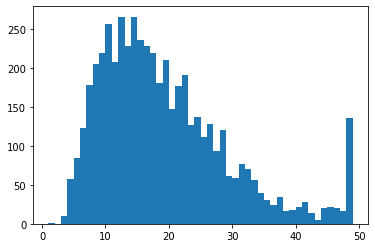

In [136]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [137]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1)

In [138]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [139]:
bert_inputs.shape

(3, 5180, 50)

In [140]:
trainSentence_ids = bert_inputs[0][:train_size]
trainMasks = bert_inputs[1][:train_size]
trainSequence_ids = bert_inputs[2][:train_size]

devSentence_ids = bert_inputs[0][train_size:train_size+dev_size]
devMasks = bert_inputs[1][train_size:train_size+dev_size]
devSequence_ids = bert_inputs[2][train_size:train_size+dev_size]

testSentence_ids = bert_inputs[0][train_size+dev_size:]
testMasks = bert_inputs[1][train_size+dev_size:]
testSequence_ids = bert_inputs[2][train_size+dev_size:]

nerLabels_train = nerLabels[:train_size]
nerLabels_dev = nerLabels[train_size:train_size+dev_size]
nerLabels_test = nerLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_dev = np.array(nerLabels_dev)
nerLabels_test = np.array(nerLabels_test)

In [141]:
trainSentence_ids.shape
devSentence_ids.shape
testSentence_ids.shape

(4230, 50)

(150, 50)

(800, 50)

In [142]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_dev_k = nerLabels_dev[k_start:k_end_dev]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [143]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [144]:
numNerClasses = 7

### Construct BERT model

In [145]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0000005) #, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False

In [146]:
print(bert_inputs_train_k[0][1])
print(labels_train_k[1])

[  101  2009  2038  2053  4950  2021  1010  1045  2064  2467  4965  1998
 16500  2028  3733  1012   102     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
[3 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
model = ner_model(max_length + 1, train_layers=-1, optimizer = adam_customized)

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_dev_k, {"ner": labels_dev_k }),
    epochs=10,
    batch_size=8
)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 50, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 50, 7), dtype=tf.float32, name=None), name='ner/truediv:0', description="created by layer 'ner'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
___________________________________________________________________________

### Predict on test

In [ ]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]
result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [ ]:
print(np.argmax(result, axis=2)[8])

In [ ]:
print(nerLabels_test[8])

### Format BERT results

In [ ]:
# index categorical label dataframe for the predicted tag
format_result = []
for sample in np.argmax(result, axis=2):
    format_result.append([nerClassDict[label] for label in sample])
    
len(format_result)

In [ ]:
# index categorical label dataframe for the true tag
format_label = []
for sample in nerLabels_test:
    format_label.append([nerClassDict[label] for label in sample])
    
len(format_label)

In [ ]:
# get real tokens back
format_sent = [tokenizer.convert_ids_to_tokens(sample) for sample in X_test[0]]

In [ ]:
predictions_flat = [pred for preds in format_result for pred in preds]
labels_flat = [label for labels in format_label for label in labels]
sentence_flat = [token for sample in X_test[0] for token in tokenizer.convert_ids_to_tokens(sample)]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label in ['O','B','I','nerX']:
        clean_preds.append(pred)
        clean_labels.append(label)
print(Counter(clean_preds))
print(confusion_matrix(clean_labels,clean_preds))

In [85]:
results_flatten = [token for result in format_result for token in result]
print(Counter(results_flatten))
unf_results_flatten = [token for result in np.argmax(result, axis=2) for token in result]
print(Counter(unf_results_flatten))

Counter({'[nerPAD]': 25705, 'O': 10844, 'nerX': 868, '[nerCLS]': 800, '[nerSEP]': 800, 'B': 631, 'I': 352})
Counter({4: 25705, 2: 10844, 6: 868, 3: 800, 5: 800, 0: 631, 1: 352})


In [86]:
ae_laptop_dev_df_bert['results_1000'] = format_result

## AE BERT - Vary training data size = 100

### Format BERT inputs

In [92]:
print('starting training size',len(ae_laptop_train))
print('total labeled data',len(ae_laptop_train)+len(ae_laptop_dev)+len(ae_laptop_test))
var_size = 100
print('new starting training size',var_size)
print('new total labeled data',var_size+len(ae_laptop_dev)+len(ae_laptop_test))
var_ae_laptop_train = dict()
for size in range(var_size):
  # samples with replacement
  key,val = random.choice(list(ae_laptop_train.items()))
  var_ae_laptop_train[key] = val


starting training size 2895
total labeled data 3845
new starting training size 100
new total labeled data 1050


In [93]:
batch_sentences = [val['sentence'] for key, val in var_ae_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in ae_laptop_test.items()])
train_size = len(var_ae_laptop_train)*5
dev_size = len(ae_laptop_dev)
test_size = len(ae_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
assert len(batch_sentences) == train_size+dev_size+test_size

495
150
800


In [94]:
batch_label = [val['label'] for key, val in var_ae_laptop_train.items()]*5
batch_label.extend([val['label'] for key, val in ae_laptop_dev.items()])
batch_label.extend([val['label'] for key, val in ae_laptop_test.items()])

len(batch_label)

1445

In [95]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [96]:
def addWord(word, ner):
    """
    Convert a word into a word token and add supplied NER labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    return addDict

In [97]:
max_length = 50

In [98]:
# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
nerTokens = ['[nerCLS]']

for sentence,label in zip(batch_sentences,batch_label):
    for ind,token in enumerate(sentence):
        word, ner = token,label[ind]

        # if new sentence starts
        if (ind == 0):            

            sentenceLength = min(max_length -1, len(sentenceTokens))
            sentLengthList.append(sentenceLength)

            # Create space for at least a final '[SEP]' token
            if sentenceLength >= max_length - 1: 
                sentenceTokens = sentenceTokens[:max_length - 2]
                nerTokens = nerTokens[:max_length - 2]

            # add a ['SEP'] token and padding

            sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
            nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )

            sentenceList.append(sentence)

            sentenceTokenList.append(sentenceTokens)

            bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
            bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
            bertSequenceIDs.append([0] * (max_length))

            nerTokenList.append(nerTokens)

            sentence = ''
            sentenceTokens = ['[CLS]']
            nerTokens = ['[nerCLS]']

            sentence += ' ' + word

        addDict = addWord(word, ner)

        sentenceTokens += addDict['wordToken']
        nerTokens += addDict['nerToken']

In [99]:
print(sentenceTokenList[1])

['[CLS]', 'we', 'were', 'pc', 'users', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [100]:
print(nerTokenList[1])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [101]:
print(bertMasks[1])

[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [102]:
print(bertSequenceIDs[1])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


(array([  1.,   0.,   0.,   2.,  10.,  43.,  48.,  65., 110.,  71.,  63.,
         81.,  83.,  75.,  96.,  58.,  64.,  91.,  40.,  38.,  37.,  51.,
         22.,  32.,  27.,  23.,  24.,  20.,  17.,  14.,  22.,  15.,  11.,
          5.,  15.,   9.,   5.,   7.,   8.,   7.,   3.,   4.,   0.,  10.,
          1.,   0.,   1.,  16.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <a list of 48 Patch objects>)

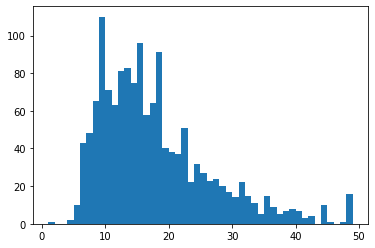

In [103]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [104]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1)

In [105]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [106]:
bert_inputs.shape

(3, 1445, 50)

In [107]:
trainSentence_ids = bert_inputs[0][:train_size]
trainMasks = bert_inputs[1][:train_size]
trainSequence_ids = bert_inputs[2][:train_size]

devSentence_ids = bert_inputs[0][train_size:train_size+dev_size]
devMasks = bert_inputs[1][train_size:train_size+dev_size]
devSequence_ids = bert_inputs[2][train_size:train_size+dev_size]

testSentence_ids = bert_inputs[0][train_size+dev_size:]
testMasks = bert_inputs[1][train_size+dev_size:]
testSequence_ids = bert_inputs[2][train_size+dev_size:]

nerLabels_train = nerLabels[:train_size]
nerLabels_dev = nerLabels[train_size:train_size+dev_size]
nerLabels_test = nerLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

nerLabels_train = np.array(nerLabels_train)
nerLabels_dev = np.array(nerLabels_dev)
nerLabels_test = np.array(nerLabels_test)

In [108]:
trainSentence_ids.shape
devSentence_ids.shape
testSentence_ids.shape

(495, 50)

(150, 50)

(800, 50)

In [109]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = nerLabels_train[k_start:k_end_train]
labels_dev_k = nerLabels_dev[k_start:k_end_dev]
labels_test_k = nerLabels_test[k_start:k_end_test]

In [110]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [111]:
numNerClasses = 7

### Construct BERT model

In [112]:
adam_customized = tf.keras.optimizers.Adam(lr=0.0000005) #, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False

In [113]:
print(bert_inputs_train_k[0][1])
print(labels_train_k[1])

[ 101 2057 2020 7473 5198 1012  102    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
[3 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [114]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# retrain all layers
model = ner_model(max_length + 1, train_layers=-1, optimizer = adam_customized)

model.fit(
    bert_inputs_train_k, 
    {"ner": labels_train_k },
    validation_data=(bert_inputs_dev_k, {"ner": labels_dev_k }),
    epochs=10,
    batch_size=8
)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 50, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 50, 7), dtype=tf.float32, name=None), name='ner/truediv:0', description="created by layer 'ner'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
___________________________________________________________________________

### Predict on test

In [115]:
bert_inputs_infer = [X_test[0], X_test[1], X_test[2]]
result = model.predict(
    bert_inputs_infer, 
    batch_size=16
)

In [116]:
print(np.argmax(result, axis=2)[8])

[4 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [117]:
print(nerLabels_test[8])

[3 2 2 2 2 2 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


### Format BERT results

In [118]:
# index categorical label dataframe for the predicted tag
format_result = []
for sample in np.argmax(result, axis=2):
    format_result.append([nerClassDict[label] for label in sample])
    
len(format_result)

800

In [119]:
# index categorical label dataframe for the true tag
format_label = []
for sample in nerLabels_test:
    format_label.append([nerClassDict[label] for label in sample])
    
len(format_label)

800

In [120]:
# get real tokens back
format_sent = [tokenizer.convert_ids_to_tokens(sample) for sample in X_test[0]]

In [121]:
predictions_flat = [pred for preds in format_result for pred in preds]
labels_flat = [label for labels in format_label for label in labels]
sentence_flat = [token for sample in X_test[0] for token in tokenizer.convert_ids_to_tokens(sample)]

clean_preds = []
clean_labels = []

for pred, label in zip(predictions_flat, labels_flat):
    if label in ['O','B','I','nerX']:
        clean_preds.append(pred)
        clean_labels.append(label)
print(Counter(clean_preds))
print(confusion_matrix(clean_labels,clean_preds))

Counter({'O': 10844, 'nerX': 868, 'B': 631, 'I': 352})
[[  540     7   101     0]
 [   42   325    78     2]
 [   49    19 10641    13]
 [    0     1    24   853]]


In [122]:
results_flatten = [token for result in format_result for token in result]
print(Counter(results_flatten))
unf_results_flatten = [token for result in np.argmax(result, axis=2) for token in result]
print(Counter(unf_results_flatten))

Counter({'[nerPAD]': 25705, 'O': 10844, 'nerX': 868, '[nerCLS]': 800, '[nerSEP]': 800, 'B': 631, 'I': 352})
Counter({4: 25705, 2: 10844, 6: 868, 3: 800, 5: 800, 0: 631, 1: 352})


In [123]:
ae_laptop_dev_df_bert['results_100'] = format_result

In [ ]:
ae_laptop_dev_df_bert.to_csv('../data/results/ae_bert.csv')

## AE evaluation - SemEval14

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/  
- partial boundary match over the surface string

In [55]:
# TODO amend this tree structure for all predictions as well
print('\nGold Standard:')
# tag every sentence with the pos
gold_tree = ae_laptop_test_df['sentence'].apply(lambda x: nltk.pos_tag(x))
print(gold_tree)
iob_gold_tree = [nltk.Tree('S',
                           [(el[0], el[1], ae_laptop_test_df.iloc[tree_ind]['label'][ind])
                            if ae_laptop_test_df.iloc[tree_ind]['label'][ind]=='O'
                            else (el[0], el[1], ae_laptop_test_df.iloc[tree_ind]['label'][ind] + '-NP')
                            for ind,el in enumerate(tree)])
                for tree_ind, tree in enumerate(gold_tree)]
ae_laptop_test_df['iob_gold_tree'] = iob_gold_tree
ae_laptop_test_df.head()


Gold Standard:
0      [(Boot, NNP), (time, NN), (is, VBZ), (super, J...
1      [(tech, JJ), (support, NN), (would, MD), (not,...
2      [(but, CC), (in, IN), (resume, NN), (this, DT)...
3      [(Set, NNP), (up, RP), (was, VBD), (easy, JJ),...
4      [(Did, NNP), (not, RB), (enjoy, VB), (the, DT)...
                             ...                        
795    [(This, DT), (hardware, NN), (seems, VBZ), (to...
796    [(I, PRP), ('m, VBP), (done, VBN), (with, IN),...
797    [(I, PRP), ('ve, VBP), (had, VBD), (it, PRP), ...
798    [(the, DT), (latest, JJS), (version, NN), (doe...
799    [(Screen, NNP), (-, :), (although, IN), (some,...
Name: sentence, Length: 800, dtype: object


,label,sentence,predictions,predictions_1,iob_gold_tree
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh...","[B, I, O, O, O, O, O, O, O, O, B, O, O, B, O]","[B, I, O, O, O, O, O, O, O, O, O, O, O, B, O]","[(Boot, NNP, B-NP), (time, NN, I-NP), (is, VBZ..."
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ...","[(tech, JJ, B-NP), (support, NN, I-NP), (would..."
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]","[O, O, B, O, B, O, O]","[O, O, B, O, B, O, O]","[(but, CC, O), (in, IN, O), (resume, NN, O), (..."
3,"[B, I, O, O, O]","[Set, up, was, easy, .]","[B, O, O, O, O]","[B, O, O, O, O]","[(Set, NNP, B-NP), (up, RP, I-NP), (was, VBD, ..."
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t...","[B, O, O, O, O, B, O, O, O, B, O]","[B, O, O, O, O, B, O, O, O, O, O]","[(Did, NNP, O), (not, RB, O), (enjoy, VB, O), ..."


In [56]:
def get_entities(sentence_lst, predictions_lst):
    """
    Reformat the IOB structure to get the actual entities from the sentence
    """
    
    # for every sentence, iterate through
    all_entities = []
    for sample in range(len(predictions_lst)):
    
        # get indices where entities are identified
        predictions = np.array(predictions_lst[sample])
        ind = (predictions == 'B') | (predictions == 'I')
        
        # create list of numerical indices and boolean indices. ex. [(4, True), (10, True), (11, True), (15, True)]
        ind_tuple = [num_ind for num_ind in list(enumerate(ind)) if num_ind[1]==True]
        
        # get the sentence of interest. identify what these entities are
        sentence = np.array(sentence_lst[sample])

        # group the phrases together
        entities = []
        for subset,num_ind_tuple in zip(sentence[ind], ind_tuple): # [('price', (4, True)), ('netbook', (10, True)), ('*', (11, True)), ('machine', (15, True))]
            # put the B in entities
            if predictions[num_ind_tuple[0]][0] == 'B':
                entities.append([subset])
            # if the tag is I and it should have been a B. Fix in post processing.
            elif (predictions[num_ind_tuple[0]][0] == 'I') & (len(entities)==0):
                entities.append([subset])
            # if the tag is I, add to the last item of the list
            elif predictions[num_ind_tuple[0]][0] == 'I':
                last_entry = entities.pop()
                last_entry.append(subset)
                entities.append(last_entry)
            # there should not be any 'O' indices here
            else:
                print('Error')
        all_entities.append(entities)
    return(all_entities)

In [57]:
def get_ae_eval_features(gold_entities,prediction_entities,verbose=False):
    # TODO may later need to update these calculations to encompass sentence location.
    y_true_df = pd.DataFrame([[ind,sub_el] for ind,el in enumerate(gold_entities) for sub_el in el], columns=['sample_index','entity'])
    y_pred_df = pd.DataFrame([[ind,sub_el] for ind,el in enumerate(prediction_entities) for sub_el in el], columns=['sample_index','entity'])
    print('True')
    display(y_true_df.head())
    print('Pred')
    display(y_pred_df.head())

    cor = 0
    inc = 0
    par = 0
    mis = 0
    spu = 0

    for el in range(len(gold_entities)):
        if verbose:
            print('\n',el)
        true_subset = y_true_df[y_true_df.sample_index == el]
        pred_subset = y_pred_df[y_pred_df.sample_index == el]
        true_entities = set(true_subset.entity.apply(lambda x: '_'.join(x)))
        pred_entities = set(pred_subset.entity.apply(lambda x: '_'.join(x)))
        if verbose:
            print('True')
            print(true_entities)
            print('Pred')
            print(pred_entities)

        # get correct
        cor_entities = true_entities & pred_entities
        if verbose:
            print(f'Correct entities: {cor_entities}')
        cor += len(cor_entities)
        true_entities = true_entities - cor_entities
        pred_entities = pred_entities - cor_entities

        # get partial and missed
        for true in true_entities:
            # Take into account if the prediction contains a portion of the correct and if correct contains a portion of the prediction
            par_entities = set([pred for pred in pred_entities if (true in pred) | (pred in true)])
            if len(par_entities) != 0:
                if verbose:
                    print(f'Partial entities: {set([true])}')
                par += len(par_entities)
                true_entities = true_entities - set([true])
                pred_entities = pred_entities - par_entities
            else:
                if verbose:
                    print(f'Missed entities: {set([true])}')
                mis += 1
                true_entities = true_entities - set([true])

        if len(true_entities) == 0:
            if verbose:
                print(f'Spurious entities: {pred_entities}')
            spu += len(pred_entities)
        else:
            print('Error')

    print(f'\nCorrect: {cor}')
    print(f'Partial: {par}')
    print(f'Missed: {mis}')
    print(f'Spurious: {spu}')
    return(cor,par,mis,spu,inc)

In [58]:
def get_ae_eval(sentence_lst, y_true, y_pred,bert= False, verbose=False):
    """
    Get entity recognition evaluations accoridng to the partial match SemEval strategy
    """
    if bert:
      gold_entities = bert_entities(sentence_lst,y_true)
      prediction_entities = bert_entities(sentence_lst,y_pred)
    else:
      prediction_entities = get_entities(sentence_lst,y_pred)
      gold_entities = get_entities(sentence_lst,y_true)
    
    cor,par,mis,spu,inc = get_ae_eval_features(gold_entities,prediction_entities,verbose=verbose)
    
    pos_eval = cor + inc + par + mis
    act_eval = cor + inc + par + spu

    precision = (cor + .5 * par) / act_eval
    recall = (cor + .5 * par) / pos_eval
    f1 = ( 2* precision * recall) / (precision + recall)
    
    print(f'\nPrecision: \t{precision}')
    print(f'Recall: \t{recall}')
    print(f'F1-Score: \t{f1}')
    return(precision, recall, f1)

In [59]:
get_ae_eval(ae_laptop_test_df.sentence,ae_laptop_test_df.label,ae_laptop_test_df.predictions)

True


,sample_index,entity
0,0,"[Boot, time]"
1,1,"[tech, support]"
2,3,"[Set, up]"
3,4,"[Windows, 8]"
4,4,"[touchscreen, functions]"


Pred


,sample_index,entity
0,0,"[Boot, time]"
1,0,[seconds]
2,0,[minute]
3,1,[support]
4,1,[problem]



Correct: 422
Partial: 192
Missed: 75
Spurious: 1336

Precision: 	0.26564102564102565
Recall: 	0.7518142235123367
F1-Score: 	0.3925729442970822


(0.26564102564102565, 0.7518142235123367, 0.3925729442970822)

In [60]:
get_ae_eval(ae_laptop_test_df.sentence,ae_laptop_test_df.label,ae_laptop_test_df.predictions_1)

True


,sample_index,entity
0,0,"[Boot, time]"
1,1,"[tech, support]"
2,3,"[Set, up]"
3,4,"[Windows, 8]"
4,4,"[touchscreen, functions]"


Pred


,sample_index,entity
0,0,"[Boot, time]"
1,0,[minute]
2,1,[support]
3,1,[problem]
4,1,[plan]



Correct: 327
Partial: 223
Missed: 140
Spurious: 1094

Precision: 	0.26672749391727496
Recall: 	0.6355072463768116
F1-Score: 	0.37574978577549273


(0.26672749391727496, 0.6355072463768116, 0.37574978577549273)

In [62]:
# bert results - full
get_ae_eval(format_sent,format_label,format_result,bert=False,verbose=True)

True


,sample_index,entity
0,1,"[boot, time]"
1,2,"[tech, support]"
2,4,"[set, up]"
3,5,"[windows, 8]"
4,5,"[touch, functions]"


Pred


,sample_index,entity
0,1,"[boot, time]"
1,2,"[tech, support]"
2,4,"[set, up]"
3,5,"[windows, 8]"
4,5,"[touch, functions]"


Streaming output truncated to the last 5000 lines.
{'shipping', 'service'}
Correct entities: {'shipping', 'service'}
Spurious entities: set()

 191
True
set()
Pred
set()
Correct entities: set()
Spurious entities: set()

 192
True
set()
Pred
set()
Correct entities: set()
Spurious entities: set()

 193
True
set()
Pred
{'mini'}
Correct entities: set()
Spurious entities: {'mini'}

 194
True
{'performance', 'built_-_in_applications', 'ip'}
Pred
{'performance', 'ip', 'built_-_in', 'applications', 'camera'}
Correct entities: {'performance', 'ip'}
Partial entities: {'built_-_in_applications'}
Spurious entities: {'camera'}

 195
True
set()
Pred
set()
Correct entities: set()
Spurious entities: set()

 196
True
{'hard_drive', 'samsung_83_ss'}
Pred
{'hard_drive'}
Correct entities: {'hard_drive'}
Missed entities: {'samsung_83_ss'}
Spurious entities: set()

 197
True
set()
Pred
set()
Correct entities: set()
Spurious entities: set()

 198
True
set()
Pred
set()
Correct entities: set()
Spurious entitie

(0.827917282127031, 0.8316023738872403, 0.8297557364914878)

In [63]:
format_sent[326]

['[CLS]',
 'i',
 'like',
 'the',
 'design',
 'and',
 'ease',
 'of',
 'use',
 'with',
 'the',
 'keyboard',
 ',',
 'plenty',
 'of',
 'ports',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [91]:
# bert - 1000
get_ae_eval(format_sent,format_label,format_result,bert=True,verbose=False)

True


,sample_index,entity
0,1,boot_time
1,2,tech_support
2,4,set_up
3,5,windows_8
4,5,touch##screen_functions


Pred


,sample_index,entity
0,1,boot_time
1,2,tech_support
2,4,set_up
3,5,windows_8
4,5,touch##screen_functions



Correct: 477
Partial: 109
Missed: 81
Spurious: 62

Precision: 	0.8202160493827161
Recall: 	0.7968515742128935
F1-Score: 	0.8083650190114068


(0.8202160493827161, 0.7968515742128935, 0.8083650190114068)

In [124]:
# bert - 100
get_ae_eval(format_sent,format_label,format_result,bert=True,verbose=False)

True


,sample_index,entity
0,1,boot_time
1,2,tech_support
2,4,set_up
3,5,windows_8
4,5,touch##screen_functions


Pred


,sample_index,entity
0,1,boot_time
1,2,tech_support
2,4,set_up
3,5,windows_8
4,5,touch##screen_functions



Correct: 477
Partial: 109
Missed: 81
Spurious: 62

Precision: 	0.8202160493827161
Recall: 	0.7968515742128935
F1-Score: 	0.8083650190114068


(0.8202160493827161, 0.7968515742128935, 0.8083650190114068)

## AE evaluation - Token Accuracy

In [ ]:
def get_accuracy(true,predictions):
    accuracy = []
    for true_el, predict_el in zip(true,predictions):
        accuracy.append((np.array(predict_el) == np.array(true_el)).sum() / (len(true_el)))
    return(accuracy)

ae_laptop_test_df['accuracy'] = get_accuracy(ae_laptop_test_df.label,ae_laptop_test_df.predictions)
ae_laptop_test_df['accuracy_1'] = get_accuracy(ae_laptop_test_df.label,ae_laptop_test_df.predictions_1)
ae_laptop_test_df.head()
ae_laptop_test_df[['accuracy','accuracy_1']].describe()

,label,sentence,predictions,predictions_1,iob_gold_tree,accuracy,accuracy_1
0,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O]","[Boot, time, is, super, fast, ,, around, anywh...","[B, I, O, O, O, O, O, O, O, O, B, O, O, B, O]","[B, I, O, O, O, O, O, O, O, O, O, O, O, B, O]","[(Boot, NNP, B-NP), (time, NN, I-NP), (is, VBZ...",0.866667,0.933333
1,"[B, I, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[tech, support, would, not, fix, the, problem,...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ...","[O, B, O, O, O, O, B, O, O, O, O, B, O, O, O, ...","[(tech, JJ, B-NP), (support, NN, I-NP), (would...",0.764706,0.764706
2,"[O, O, O, O, O, O, O]","[but, in, resume, this, computer, rocks, !]","[O, O, B, O, B, O, O]","[O, O, B, O, B, O, O]","[(but, CC, O), (in, IN, O), (resume, NN, O), (...",0.714286,0.714286
3,"[B, I, O, O, O]","[Set, up, was, easy, .]","[B, O, O, O, O]","[B, O, O, O, O]","[(Set, NNP, B-NP), (up, RP, I-NP), (was, VBD, ...",0.800000,0.800000
4,"[O, O, O, O, O, B, I, O, B, I, O]","[Did, not, enjoy, the, new, Windows, 8, and, t...","[B, O, O, O, O, B, O, O, O, B, O]","[B, O, O, O, O, B, O, O, O, O, O]","[(Did, NNP, O), (not, RB, O), (enjoy, VB, O), ...",0.636364,0.636364


,accuracy,accuracy_1
count,800.000000,800.000000
mean,0.827023,0.831191
std,0.117612,0.127836
min,0.200000,0.200000
25%,0.756466,0.760000
50%,0.833333,0.846154
75%,0.909091,0.916667
max,1.000000,1.000000


## Export samples that are well / poorly extracted

In [ ]:
def get_bad_examples(n = 1):
    ind = np.argpartition(ae_laptop_test_df.accuracy + ae_laptop_test_df.accuracy_1,n)[:n]
    print(ind)
    sort_ind = ind[np.argsort((ae_laptop_test_df.accuracy + ae_laptop_test_df.accuracy_1).iloc[ind])]
    bad_example = ae_laptop_test_df.iloc[sort_ind]
    
    display(bad_example)
    print(*[' '.join(sent) for sent in bad_example.sentence],sep='\n')
    
get_bad_examples(3)

def get_good_examples(n = 1):
    ind = np.argpartition(ae_laptop_test_df.accuracy + ae_laptop_test_df.accuracy_1,-n)[-n:]
    print(ind)
    sort_ind = ind[np.argsort((ae_laptop_test_df.accuracy + ae_laptop_test_df.accuracy_1).iloc[ind])]
    good_example = ae_laptop_test_df.iloc[sort_ind]
    
    display(good_example)
    print(*[' '.join(sent) for sent in good_example.sentence],sep='\n')
# good_example = ae_laptop_test_df.iloc[np.argmax(ae_laptop_test_df.accuracy + ae_laptop_test_df.accuracy_1)]
get_good_examples(3)

0    165
1    532
2    632
dtype: int64


,label,sentence,predictions,predictions_1,iob_gold_tree,accuracy,accuracy_1
165,"[O, O, O, O, O]","[HUGE, Apple, MAC, Fan, !]","[B, I, I, I, O]","[B, I, I, I, O]","[(HUGE, NNP, O), (Apple, NNP, O), (MAC, NNP, O...",0.200000,0.200000
532,"[O, O, O, O, O, O, O, O, O, O, O, O, O]","[i, FINALLY, DID, IT, AND, THIS, MACHINE, IS, ...","[B, I, I, I, I, I, I, O, O, B, I, I, O]","[B, O, B, I, I, I, I, O, O, B, I, I, O]","[(i, NN, O), (FINALLY, NNPS, O), (DID, NNP, O)...",0.230769,0.307692
632,"[O, B, O]","[Nice, packing, .]","[B, I, O]","[B, I, O]","[(Nice, NNP, O), (packing, NN, B-NP), (., ., O)]",0.333333,0.333333


HUGE Apple MAC Fan !
i FINALLY DID IT AND THIS MACHINE IS THE WAY TO GO !
Nice packing .
797    346
798    354
799    321
dtype: int64


,label,sentence,predictions,predictions_1,iob_gold_tree,accuracy,accuracy_1
346,"[O, O, B, O, B, O, B, O, B, I, O]","[!, Excelent, performance, ,, usability, ,, pr...","[O, O, B, O, B, O, B, O, B, I, O]","[O, O, B, O, B, O, B, O, B, I, O]","[(!, ., O), (Excelent, JJ, O), (performance, N...",1.0,1.0
354,"[O, O, O, B, I, O]","[I, love, the, form, factor, .]","[O, O, O, B, I, O]","[O, O, O, B, I, O]","[(I, PRP, O), (love, VBP, O), (the, DT, O), (f...",1.0,1.0
321,"[O, B, O, O, O, O, O, O, O, O, O, O, O]","[The, memory, was, gone, and, it, was, not, ab...","[O, B, O, O, O, O, O, O, O, O, O, O, O]","[O, B, O, O, O, O, O, O, O, O, O, O, O]","[(The, DT, O), (memory, NN, B-NP), (was, VBD, ...",1.0,1.0


! Excelent performance , usability , presentation and time response .
I love the form factor .
The memory was gone and it was not able to be used .


# ASC

## ASC baseline - VADER

In [148]:
def vader_asc(sentence_lst):
    """
    For every sentence in the list, tag it as a positive/negative sentiment based on the sum of the words.
    """
    analyzer = SentimentIntensityAnalyzer()
    pos_neg_tag_lst = []
    for ind,sentence in enumerate(sentence_lst):
        vs = analyzer.polarity_scores(sentence)
        pos_neg_tag = 'negative' if vs['compound'] <= -0.05 else 'positive' if vs['compound'] >= 0.05 else 'neutral' 
        # print first 10 examples
        if ind <10: print("{:-<65} {} ({})".format(sentence, str(vs['compound']),pos_neg_tag))
        pos_neg_tag_lst.append(pos_neg_tag)
    return(pos_neg_tag_lst)

asc_laptop_test_df['predictions'] = vader_asc(asc_laptop_test_df.sentence)

the retina display display make pictures i took years ago jaw dropping. 0.0 (neutral)
Needs a CD/DVD drive and a bigger power switch.------------------ 0.0 (neutral)
Needs a CD/DVD drive and a bigger power switch.------------------ 0.0 (neutral)
The battery is not as shown in the product photos.--------------- 0.0 (neutral)
It feels cheap, the keyboard is not very sensitive.-------------- 0.0 (neutral)
Shipping was quick and product described was the product sent and so much more... 0.0 (neutral)
I've had it for about 2 months now and found no issues with software or updates. -0.296 (negative)
The only thing I miss is that my old Alienware laptop had backlit keys. -0.1531 (negative)
Unfortunately, it runs XP and Microsoft is dropping support next April. 0.5622 (positive)
Unfortunately, it runs XP and Microsoft is dropping support next April. 0.5622 (positive)


## ASC BERT

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [40]:
batch_sentences = [val['sentence'] for key, val in asc_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_test.items()])
train_size = len(asc_laptop_train)*5
dev_size = len(asc_laptop_dev)
test_size = len(asc_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
print(train_size+dev_size+test_size)

10815
150
638
11603


In [44]:
batch_terms = [val['term'] for key, val in asc_laptop_train.items()]*5
batch_terms.extend([val['term'] for key, val in asc_laptop_dev.items()])
batch_terms.extend([val['term'] for key, val in asc_laptop_test.items()])

['use', 'noise', 'force', 'expense', 'word processor']

In [23]:
batch_label = [val['polarity'] for key, val in asc_laptop_train.items()]*5
batch_label.extend([val['polarity'] for key, val in asc_laptop_dev.items()])
batch_label.extend([val['polarity'] for key, val in asc_laptop_test.items()])

In [60]:
max_length=50
bert_inputs = tokenizer(batch_terms, batch_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [47]:
label_encoder = LabelEncoder().fit(batch_label)
ascLabels = label_encoder.transform(batch_label)
label_encoder.classes_
batch_label[:5]
ascLabels[:5]

array(['negative', 'neutral', 'positive'], dtype='<U8')

['positive', 'positive', 'positive', 'negative', 'negative']

array([2, 2, 2, 0, 0])

In [48]:
bert_inputs

{'input_ids': <tf.Tensor: shape=(11603, 50), dtype=int32, numpy=
array([[  101,  2224,   102, ...,     0,     0,     0],
       [  101,  5005,   102, ...,     0,     0,     0],
       [  101,  2486,   102, ...,     0,     0,     0],
       ...,
       [  101,  3645,  1022, ...,     0,     0,     0],
       [  101, 14743,   102, ...,     0,     0,     0],
       [  101, 10453,   102, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(11603, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(11603, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [49]:
trainSentence_ids = bert_inputs['input_ids'][:train_size]
trainMasks = bert_inputs['attention_mask'][:train_size]
trainSequence_ids = bert_inputs['token_type_ids'][:train_size]

devSentence_ids = bert_inputs['input_ids'][train_size:train_size+dev_size]
devMasks = bert_inputs['attention_mask'][train_size:train_size+dev_size]
devSequence_ids = bert_inputs['token_type_ids'][train_size:train_size+dev_size]

testSentence_ids = bert_inputs['input_ids'][train_size+dev_size:]
testMasks = bert_inputs['attention_mask'][train_size+dev_size:]
testSequence_ids = bert_inputs['token_type_ids'][train_size+dev_size:]

ascLabels_train = ascLabels[:train_size]
ascLabels_dev = ascLabels[train_size:train_size+dev_size]
ascLabels_test = ascLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

ascLabels_train = np.array(ascLabels_train)
ascLabels_dev = np.array(ascLabels_dev)
ascLabels_test = np.array(ascLabels_test)

In [127]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = ascLabels_train[k_start:k_end_train]
labels_dev_k = ascLabels_dev[k_start:k_end_dev]
labels_test_k = ascLabels_test[k_start:k_end_test]

In [128]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [129]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    y_label = tf.reshape(Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    mask = (y_label == y_label)   # This mask is used to remove all tokens that do not correspond to the original base text.

    y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    y_flat_pred = tf.reshape(Flatten()(tf.cast(y_pred, tf.float32)),[-1, 3])
    
    y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(sparse_categorical_crossentropy(y_label_masked, y_flat_pred_masked,from_logits=False ))


In [132]:
def asc_model(max_input_length, train_layers, optimizer):
    global bert_sequence
    """
    Implementation of ASC model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), dtype='int32', name="segment_ids")
    
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    
    
    # Note: Bert layer from Hugging Face returns two values: sequence ouput, and pooled output. Here, we only want
    # the former. (See https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) 
    
    bert_layer = TFBertModel.from_pretrained('bert-base-uncased')
    
    # Freeze layers, i.e. only train number of layers specified, starting from the top
    
    if not train_layers == -1:
        
        retrain_layers = []
    
        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)

        for w in bert_layer.weights:
            if not any([x in w.name for x in retrain_layers]):
                w._trainable = False

        # End of freezing section
    
    bert_sequence = bert_layer(bert_inputs)[1] # take the pooled output here
    
    print('Let us check the shape of the BERT layer output:', bert_sequence)
    
    dense = tf.keras.layers.Dense(512, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)

    pred = tf.keras.layers.Dense(3, activation='softmax', name='asc')(dense)
     
    print('pred: ', pred)
    
    loss = custom_loss

    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    
    
    model.summary()
    
    return model

In [133]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = asc_model(max_length+1,train_layers=-1, optimizer=optimizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.fit(bert_inputs_train_k,labels_train_k ,validation_data=(bert_inputs_dev_k, labels_dev_k), epochs=5, batch_size=16)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='asc/Softmax:0', description="created by layer 'asc'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (Input

In [110]:
Counter(labels_train_k)

Counter({0: 4000, 1: 2165, 2: 4650})

In [134]:
results = model.predict([X_test[0],X_test[1],X_test[2]], batch_size=16)
predictions = np.argmax(results,axis=1)
asc_laptop_test_df['predictions_1'] = label_encoder.inverse_transform(predictions)

## ASC BERT - Vary training data size = 1000

In [217]:
print('starting training size',len(asc_laptop_train))
print('total labeled data',len(asc_laptop_train)+len(asc_laptop_dev)+len(asc_laptop_test))
var_size = 1000
print('new starting training size',var_size)
print('new total labeled data',var_size+len(asc_laptop_dev)+len(asc_laptop_test))
var_asc_laptop_train = dict()
for size in range(var_size):
  # samples with replacement
  key,val = random.choice(list(asc_laptop_train.items()))
  var_asc_laptop_train[key] = val


starting training size 2163
total labeled data 2951
new starting training size 1000
new total labeled data 1788


In [186]:
batch_sentences = [val['sentence'] for key, val in var_asc_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_test.items()])
train_size = len(var_asc_laptop_train)*5
dev_size = len(asc_laptop_dev)
test_size = len(asc_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
print(train_size+dev_size+test_size)

3960
150
638
4748


In [187]:
batch_terms = [val['term'] for key, val in var_asc_laptop_train.items()]*5
batch_terms.extend([val['term'] for key, val in asc_laptop_dev.items()])
batch_terms.extend([val['term'] for key, val in asc_laptop_test.items()])

In [188]:
batch_label = [val['polarity'] for key, val in var_asc_laptop_train.items()]*5
batch_label.extend([val['polarity'] for key, val in asc_laptop_dev.items()])
batch_label.extend([val['polarity'] for key, val in asc_laptop_test.items()])

In [189]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [190]:
max_length=50
bert_inputs = tokenizer(batch_terms, batch_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [191]:
label_encoder = LabelEncoder().fit(batch_label)
ascLabels = label_encoder.transform(batch_label)
label_encoder.classes_
batch_label[:5]
ascLabels[:5]

array(['negative', 'neutral', 'positive'], dtype='<U8')

['positive', 'positive', 'neutral', 'positive', 'positive']

array([2, 2, 1, 2, 2])

In [192]:
bert_inputs

{'input_ids': <tf.Tensor: shape=(4748, 50), dtype=int32, numpy=
array([[  101,  2686,   102, ...,     0,     0,     0],
       [  101, 13151,   102, ...,     0,     0,     0],
       [  101,  6046,   102, ...,     0,     0,     0],
       ...,
       [  101,  3645,  1022, ...,     0,     0,     0],
       [  101, 14743,   102, ...,     0,     0,     0],
       [  101, 10453,   102, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(4748, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4748, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [193]:
trainSentence_ids = bert_inputs['input_ids'][:train_size]
trainMasks = bert_inputs['attention_mask'][:train_size]
trainSequence_ids = bert_inputs['token_type_ids'][:train_size]

devSentence_ids = bert_inputs['input_ids'][train_size:train_size+dev_size]
devMasks = bert_inputs['attention_mask'][train_size:train_size+dev_size]
devSequence_ids = bert_inputs['token_type_ids'][train_size:train_size+dev_size]

testSentence_ids = bert_inputs['input_ids'][train_size+dev_size:]
testMasks = bert_inputs['attention_mask'][train_size+dev_size:]
testSequence_ids = bert_inputs['token_type_ids'][train_size+dev_size:]

ascLabels_train = ascLabels[:train_size]
ascLabels_dev = ascLabels[train_size:train_size+dev_size]
ascLabels_test = ascLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

ascLabels_train = np.array(ascLabels_train)
ascLabels_dev = np.array(ascLabels_dev)
ascLabels_test = np.array(ascLabels_test)

In [194]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = ascLabels_train[k_start:k_end_train]
labels_dev_k = ascLabels_dev[k_start:k_end_dev]
labels_test_k = ascLabels_test[k_start:k_end_test]

In [195]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [198]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = asc_model(max_length+1,train_layers=-1, optimizer=optimizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.fit(bert_inputs_train_k,labels_train_k ,validation_data=(bert_inputs_dev_k, labels_dev_k), epochs=5, batch_size=16)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='asc/Softmax:0', description="created by layer 'asc'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (Input

In [199]:
Counter(labels_train_k)

Counter({0: 1520, 1: 780, 2: 1660})

In [212]:
results = model.predict([X_test[0],X_test[1],X_test[2]], batch_size=16)
predictions = np.argmax(results,axis=1)
asc_laptop_test_df['predictions_2_1000'] = label_encoder.inverse_transform(predictions)


## ASC BERT - Vary training data size = 100

In [215]:
print('starting training size',len(asc_laptop_train))
print('total labeled data',len(asc_laptop_train)+len(asc_laptop_dev)+len(asc_laptop_test))
var_size = 100
print('new starting training size',var_size)
print('new total labeled data',var_size+len(asc_laptop_dev)+len(asc_laptop_test))
var_asc_laptop_train = dict()
for size in range(var_size):
  # samples with replacement
  key,val = random.choice(list(asc_laptop_train.items()))
  var_asc_laptop_train[key] = val


starting training size 2163
total labeled data 2951
new starting training size 100
new total labeled data 888


In [218]:
batch_sentences = [val['sentence'] for key, val in var_asc_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_test.items()])
train_size = len(var_asc_laptop_train)*5
dev_size = len(asc_laptop_dev)
test_size = len(asc_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
print(train_size+dev_size+test_size)

3980
150
638
4768


In [219]:
batch_terms = [val['term'] for key, val in var_asc_laptop_train.items()]*5
batch_terms.extend([val['term'] for key, val in asc_laptop_dev.items()])
batch_terms.extend([val['term'] for key, val in asc_laptop_test.items()])

In [220]:
batch_label = [val['polarity'] for key, val in var_asc_laptop_train.items()]*5
batch_label.extend([val['polarity'] for key, val in asc_laptop_dev.items()])
batch_label.extend([val['polarity'] for key, val in asc_laptop_test.items()])

In [221]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [222]:
max_length=50
bert_inputs = tokenizer(batch_terms, batch_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [223]:
label_encoder = LabelEncoder().fit(batch_label)
ascLabels = label_encoder.transform(batch_label)
label_encoder.classes_
batch_label[:5]
ascLabels[:5]

array(['negative', 'neutral', 'positive'], dtype='<U8')

['positive', 'neutral', 'positive', 'neutral', 'positive']

array([2, 1, 2, 1, 2])

In [224]:
bert_inputs

{'input_ids': <tf.Tensor: shape=(4768, 50), dtype=int32, numpy=
array([[  101,  3177,   102, ...,     0,     0,     0],
       [  101,  3898,   102, ...,     0,     0,     0],
       [  101,  4586, 16240, ...,     0,     0,     0],
       ...,
       [  101,  3645,  1022, ...,     0,     0,     0],
       [  101, 14743,   102, ...,     0,     0,     0],
       [  101, 10453,   102, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(4768, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(4768, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [225]:
trainSentence_ids = bert_inputs['input_ids'][:train_size]
trainMasks = bert_inputs['attention_mask'][:train_size]
trainSequence_ids = bert_inputs['token_type_ids'][:train_size]

devSentence_ids = bert_inputs['input_ids'][train_size:train_size+dev_size]
devMasks = bert_inputs['attention_mask'][train_size:train_size+dev_size]
devSequence_ids = bert_inputs['token_type_ids'][train_size:train_size+dev_size]

testSentence_ids = bert_inputs['input_ids'][train_size+dev_size:]
testMasks = bert_inputs['attention_mask'][train_size+dev_size:]
testSequence_ids = bert_inputs['token_type_ids'][train_size+dev_size:]

ascLabels_train = ascLabels[:train_size]
ascLabels_dev = ascLabels[train_size:train_size+dev_size]
ascLabels_test = ascLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

ascLabels_train = np.array(ascLabels_train)
ascLabels_dev = np.array(ascLabels_dev)
ascLabels_test = np.array(ascLabels_test)

In [226]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = ascLabels_train[k_start:k_end_train]
labels_dev_k = ascLabels_dev[k_start:k_end_dev]
labels_test_k = ascLabels_test[k_start:k_end_test]

In [227]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [230]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = asc_model(max_length+1,train_layers=-1, optimizer=optimizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.fit(bert_inputs_train_k,labels_train_k ,validation_data=(bert_inputs_dev_k, labels_dev_k), epochs=5, batch_size=16)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Let us check the shape of the BERT layer output: KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")
pred:  KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='asc/Softmax:0', description="created by layer 'asc'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (Input

In [231]:
Counter(labels_train_k)

Counter({0: 1415, 1: 820, 2: 1745})

In [232]:
results = model.predict([X_test[0],X_test[1],X_test[2]], batch_size=16)
predictions = np.argmax(results,axis=1)
asc_laptop_test_df['predictions_3_100'] = label_encoder.inverse_transform(predictions)


## ASC BERT - Vary training data size = 50

In [263]:
print('starting training size',len(asc_laptop_train))
print('total labeled data',len(asc_laptop_train)+len(asc_laptop_dev)+len(asc_laptop_test))
var_size = 50
print('new starting training size',var_size)
print('new total labeled data',var_size+len(asc_laptop_dev)+len(asc_laptop_test))
var_asc_laptop_train = dict()
for size in range(var_size):
  # samples with replacement
  key,val = random.choice(list(asc_laptop_train.items()))
  var_asc_laptop_train[key] = val


starting training size 2163
total labeled data 2951
new starting training size 50
new total labeled data 838


In [264]:
batch_sentences = [val['sentence'] for key, val in var_asc_laptop_train.items()]*5
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_dev.items()])
batch_sentences.extend([val['sentence'] for key, val in asc_laptop_test.items()])
train_size = len(var_asc_laptop_train)*5
dev_size = len(asc_laptop_dev)
test_size = len(asc_laptop_test)
print(train_size)
print(dev_size)
print(test_size)
print(train_size+dev_size+test_size)

250
150
638
1038


In [265]:
batch_terms = [val['term'] for key, val in var_asc_laptop_train.items()]*5
batch_terms.extend([val['term'] for key, val in asc_laptop_dev.items()])
batch_terms.extend([val['term'] for key, val in asc_laptop_test.items()])

In [266]:
batch_label = [val['polarity'] for key, val in var_asc_laptop_train.items()]*5
batch_label.extend([val['polarity'] for key, val in asc_laptop_dev.items()])
batch_label.extend([val['polarity'] for key, val in asc_laptop_test.items()])

In [267]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [268]:
max_length=50
bert_inputs = tokenizer(batch_terms, batch_sentences, padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [269]:
label_encoder = LabelEncoder().fit(batch_label)
ascLabels = label_encoder.transform(batch_label)
label_encoder.classes_
batch_label[:5]
ascLabels[:5]

array(['negative', 'neutral', 'positive'], dtype='<U8')

['neutral', 'positive', 'negative', 'positive', 'positive']

array([1, 2, 0, 2, 2])

In [270]:
bert_inputs

{'input_ids': <tf.Tensor: shape=(1038, 50), dtype=int32, numpy=
array([[  101,  7829, 11122, ...,     0,     0,     0],
       [  101,  3216,   102, ...,     0,     0,     0],
       [  101,  2773,   102, ...,     0,     0,     0],
       ...,
       [  101,  3645,  1022, ...,     0,     0,     0],
       [  101, 14743,   102, ...,     0,     0,     0],
       [  101, 10453,   102, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1038, 50), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1038, 50), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32

In [271]:
trainSentence_ids = bert_inputs['input_ids'][:train_size]
trainMasks = bert_inputs['attention_mask'][:train_size]
trainSequence_ids = bert_inputs['token_type_ids'][:train_size]

devSentence_ids = bert_inputs['input_ids'][train_size:train_size+dev_size]
devMasks = bert_inputs['attention_mask'][train_size:train_size+dev_size]
devSequence_ids = bert_inputs['token_type_ids'][train_size:train_size+dev_size]

testSentence_ids = bert_inputs['input_ids'][train_size+dev_size:]
testMasks = bert_inputs['attention_mask'][train_size+dev_size:]
testSequence_ids = bert_inputs['token_type_ids'][train_size+dev_size:]

ascLabels_train = ascLabels[:train_size]
ascLabels_dev = ascLabels[train_size:train_size+dev_size]
ascLabels_test = ascLabels[train_size+dev_size:]

X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_dev = np.array([devSentence_ids,devMasks,devSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

ascLabels_train = np.array(ascLabels_train)
ascLabels_dev = np.array(ascLabels_dev)
ascLabels_test = np.array(ascLabels_test)

In [272]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.

k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_dev = X_dev[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end_dev = k_end
    


bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_dev_k = [X_dev[0][k_start:k_end_dev], X_dev[1][k_start:k_end_dev], 
                      X_dev[2][k_start:k_end_dev]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]


labels_train_k = ascLabels_train[k_start:k_end_train]
labels_dev_k = ascLabels_dev[k_start:k_end_dev]
labels_test_k = ascLabels_test[k_start:k_end_test]

In [273]:
train_all = [bert_inputs_train_k, labels_train_k]
dev_all = [bert_inputs_dev_k, labels_dev_k]
test_all = [bert_inputs_test_k, labels_test_k]

In [276]:
tf.keras.backend.clear_session()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model = asc_model(max_length+1,train_layers=-1, optimizer=optimizer)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.fit(bert_inputs_train_k,labels_train_k ,validation_data=(bert_inputs_dev_k, labels_dev_k), epochs=5, batch_size=16)

ResourceExhaustedError: ignored

In [ ]:
Counter(labels_train_k)

In [ ]:
results = model.predict([X_test[0],X_test[1],X_test[2]], batch_size=16)
predictions = np.argmax(results,axis=1)
asc_laptop_test_df['predictions_4_10'] = label_encoder.inverse_transform(predictions)


## ASC evaluation

In [150]:
def get_asc_eval(y_true, y_pred):
    print(confusion_matrix(y_true,y_pred,labels=['negative','neutral','positive']))
    print(classification_report(y_true,y_pred,labels=['negative','neutral','positive']))
get_asc_eval(asc_laptop_test_df.polarity,asc_laptop_test_df.predictions)

[[ 61  45  22]
 [ 32  81  56]
 [ 18  66 257]]
              precision    recall  f1-score   support

    negative       0.55      0.48      0.51       128
     neutral       0.42      0.48      0.45       169
    positive       0.77      0.75      0.76       341

    accuracy                           0.63       638
   macro avg       0.58      0.57      0.57       638
weighted avg       0.63      0.63      0.63       638



In [151]:
get_asc_eval(asc_laptop_test_df.polarity,asc_laptop_test_df.predictions_1)

[[102  14  12]
 [ 50  74  45]
 [ 18  21 302]]
              precision    recall  f1-score   support

    negative       0.60      0.80      0.68       128
     neutral       0.68      0.44      0.53       169
    positive       0.84      0.89      0.86       341

    accuracy                           0.75       638
   macro avg       0.71      0.71      0.69       638
weighted avg       0.75      0.75      0.74       638



In [213]:
get_asc_eval(asc_laptop_test_df.polarity,asc_laptop_test_df['predictions_2_1000']) 

[[107  12   9]
 [ 55  73  41]
 [ 27  20 294]]
              precision    recall  f1-score   support

    negative       0.57      0.84      0.68       128
     neutral       0.70      0.43      0.53       169
    positive       0.85      0.86      0.86       341

    accuracy                           0.74       638
   macro avg       0.71      0.71      0.69       638
weighted avg       0.75      0.74      0.74       638



In [233]:
get_asc_eval(asc_laptop_test_df.polarity,asc_laptop_test_df['predictions_3_100']) 

[[106   9  13]
 [ 53  73  43]
 [ 26  16 299]]
              precision    recall  f1-score   support

    negative       0.57      0.83      0.68       128
     neutral       0.74      0.43      0.55       169
    positive       0.84      0.88      0.86       341

    accuracy                           0.75       638
   macro avg       0.72      0.71      0.69       638
weighted avg       0.76      0.75      0.74       638



In [ ]:
get_asc_eval(asc_laptop_test_df.polarity,asc_laptop_test_df['predictions_4_10']) 

## Evaluate samples that are well / poorly predicted

In [298]:
def explore_asc(pred_col):
  # do we have any that are wildly incorrect?
  with pd.option_context('display.max_colwidth', None):
    print('negative >> positive')
    display(asc_laptop_test_df[(asc_laptop_test_df.polarity == 'negative') & (asc_laptop_test_df[pred_col] == 'positive')][['term','sentence']])
    print('positive >> negative')
    display(asc_laptop_test_df[(asc_laptop_test_df.polarity == 'positive') & (asc_laptop_test_df[pred_col] == 'negative')][['term','sentence']])
  # give me back ones that are move in/out neutral
  assess = asc_laptop_test_df[(asc_laptop_test_df.polarity!= asc_laptop_test_df[pred_col])]
  display(assess.groupby(['polarity',pred_col]).size())
  display(assess.groupby(['polarity',pred_col]).size() / assess.shape[0])


In [296]:
explore_asc('predictions')

,term,sentence
962:1_1,support,"Unfortunately, it runs XP and Microsoft is dropping support next April."
609:1_0,price,"I had the same reasons as most PC users: the price, the overbearing restrictions of OSX and lack of support for games."
477:1_0,function,"My wife was so excited to open the box, but quickly came to see that it did not function as it should."
1009:1_2,pad,"I had to buy a wireless mouse to go with it, as I am old school and hate the pad, but knew that before I bought it, now it works great, need to get adjusted to the key board, as I am used to a bigger one and pounding."
609:1_2,OSX,"I had the same reasons as most PC users: the price, the overbearing restrictions of OSX and lack of support for games."
609:1_1,support for games,"I had the same reasons as most PC users: the price, the overbearing restrictions of OSX and lack of support for games."
834:1_1,USB3,A veryimportant feature is Firewire 800 which in my experience works better then USB3 (in PC enabled with USB3)I was not originally sold on the MAC OS I felt it was inferior in many ways To Windows 7.
181:1_0,OS,After fumbling around with the OS I started searching the internet for a fix and found a number of forums on fixing the issue.
160:19_0,"Apple ""Help""","Apple ""Help"" is a mixed bag."
786:876_0,aluminum,"Yes, that's a good thing, but it's made from aluminum that scratches easily."


,term,sentence
211:1_1,craftmanship,"Apple is unmatched in product quality,aesthetics,craftmanship, and customer service."
211:1_0,aesthetics,"Apple is unmatched in product quality,aesthetics,craftmanship, and customer service."
211:1_3,customer service,"Apple is unmatched in product quality,aesthetics,craftmanship, and customer service."
211:1_2,product quality,"Apple is unmatched in product quality,aesthetics,craftmanship, and customer service."
843:1_0,number pad on the keyboard,"The Dell Inspiron is fast and has a number pad on the keyboard, which I miss on my Apple laptops."
958:1_0,price tag,"Other than not being a fan of click pads (industry standard these days) and the lousy internal speakers, it's hard for me to find things about this notebook I don't like, especially considering the $350 price tag."
280:11_1,res,Screen - although some people might complain about low res which I think is ridiculous.
280:11_0,Screen,Screen - although some people might complain about low res which I think is ridiculous.
500:1_2,windows,I was a little worry at first because I don't have a lot of experience with os.x and windows has always been second nature to me after many years of using windows.
62:1_0,windows,"I switched to this because I wanted something different, even though I miss windows."


polarity  predictions
negative  neutral        45
          positive       22
neutral   negative       32
          positive       56
positive  negative       18
          neutral        66
dtype: int64

polarity  predictions
negative  neutral        0.188285
          positive       0.092050
neutral   negative       0.133891
          positive       0.234310
positive  negative       0.075314
          neutral        0.276151
dtype: float64

In [299]:
explore_asc('predictions_1')

negative >> positive


,term,sentence
1040:1_0,keyboard,"It feels cheap, the keyboard is not very sensitive."
969:5_0,backlit keys,The only thing I miss is that my old Alienware laptop had backlit keys.
1141:1_0,Windows 8,I would have given it 5 starts was it not for the fact that it had Windows 8
1150:1_0,Windows 8,I do not like too much Windows 8.
562:1_0,Windows 8,Did not enjoy the new Windows 8 and touchscreen functions.
968:5_0,voice recording,"Also, in using the built-in camera, my voice recording for my vlog sounds like the interplanetary transmissions in the ""Star Wars"" saga."
1063:166_0,Windows 8,"Lastly, Windows 8 is annoying."
75:1_2,Mac OS 10.9,"this Mac Mini does not have a built-in mic, and it would seem that its Mac OS 10.9 does not handle external microphones properly."
716:1_0,word program,It is very fast and has everything that I need except for a word program.
786:31_0,Cost,Cost is more as compared to other brands.


positive >> negative


,term,sentence
202:1_1,fans,"The Mac mini is about 8x smaller than my old computer which is a huge bonus and runs very quiet, actually the fans aren't audible unlike my old pc"
958:1_0,price tag,"Other than not being a fan of click pads (industry standard these days) and the lousy internal speakers, it's hard for me to find things about this notebook I don't like, especially considering the $350 price tag."
29:172_0,Mac tutorials,Mac tutorials do help.
1009:1_0,works,"I had to buy a wireless mouse to go with it, as I am old school and hate the pad, but knew that before I bought it, now it works great, need to get adjusted to the key board, as I am used to a bigger one and pounding."
280:11_1,res,Screen - although some people might complain about low res which I think is ridiculous.
26:4_0,Logic board,"Logic board utterly fried, cried, and laid down and died."
908:1_0,battery cycle count,"However, it did not have any scratches, ZERO battery cycle count (pretty surprised), and all the hardware seemed to be working perfectly."
787:444_0,portable computing,"The criticism has waned, and now I'd be the first to recommend an Air for truly portable computing."
25:1_0,footprint,It's silent and has a very small footprint on my desk.
29:1027_1,heat output,The nicest part is the low heat output and ultra quiet operation.


polarity  predictions_1
negative  neutral          14
          positive         12
neutral   negative         50
          positive         45
positive  negative         18
          neutral          21
dtype: int64

polarity  predictions_1
negative  neutral          0.08750
          positive         0.07500
neutral   negative         0.31250
          positive         0.28125
positive  negative         0.11250
          neutral          0.13125
dtype: float64